In [1]:
!pip3 install pathlib
!pip3 install numpy
!pip3 install pandas
!pip3 install multiprocess
!pip3 install matplotlib
!pip3 install seaborn

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import multiprocess as mp
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path = Path("../data/")
out_path = str(path / "endomondoHR_proper.json")

def process(line):
    return eval(line)

pool = mp.Pool(5) 
with open(out_path, 'r') as f:
    data = pool.map(process, f)
pool.close()
pool.join()

In [5]:
df = pd.DataFrame(data)
df = df.dropna()

In [5]:
def generate_sport_heart_rate_df(sport_type):
    heart_rate_dict = {}
    for index, row in df.iterrows():
        if row['sport'] == sport_type:
            if sport_type not in heart_rate_dict:
                heart_rate_dict[sport_type] = []
            heart_rate_dict[sport_type].extend(row['heart_rate'])

    df_heart_rate_by_type = pd.DataFrame.from_dict(heart_rate_dict).rename(columns={sport_type:'heart rate'})
    df_heart_rate_by_type['type'] = sport_type
    return df_heart_rate_by_type

In [6]:
sport_type_dfs = []
sport_types = df['sport'].unique()
for sport in sport_types:
    sport_type_dfs.append(generate_sport_heart_rate_df(sport))

KeyboardInterrupt: 

/var/folders/t2/t_vlyyqs1fx_lsym71tgvwpm0000gn/T/ipykernel_4480/3170569379.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


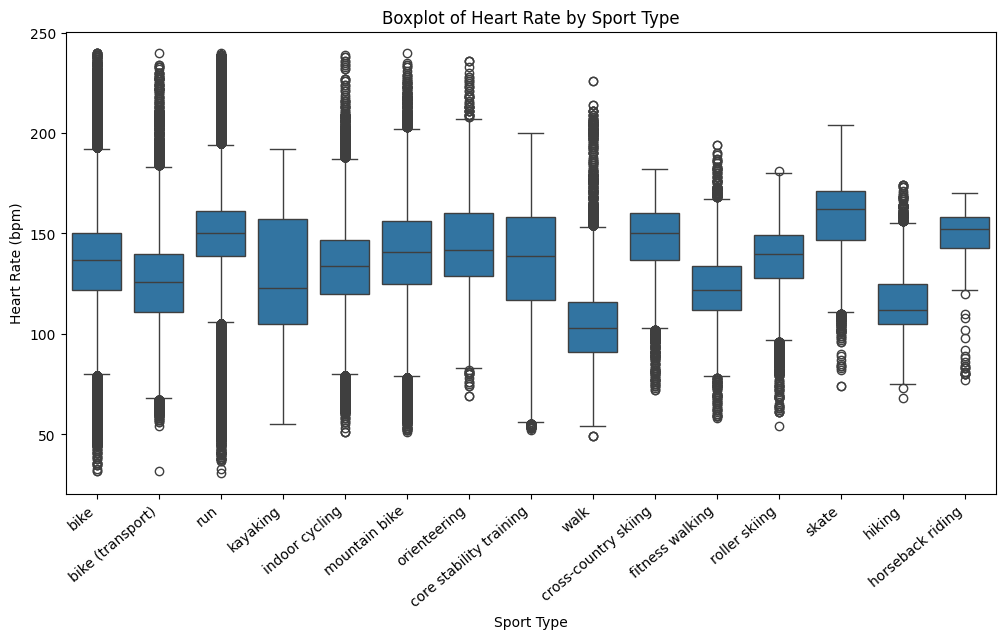

In [ ]:
df_sport_heart_rate = pd.concat(sport_type_dfs)
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df_sport_heart_rate, x='type', y='heart rate')
ax.set_xlabel('Sport Type')
ax.set_ylabel('Heart Rate (bpm)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Boxplot of Heart Rate by Sport Type')
plt.show()

## create 15 plots for each sport(timestamp VS speed, timestamp vs heart_rate)

In [23]:
df.columns

Index(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate',
       'gender', 'timestamp', 'url', 'userId', 'speed'],
      dtype='object')

In [88]:
df['sport'].unique()

array(['bike', 'bike (transport)', 'run', 'kayaking', 'indoor cycling',
       'mountain bike', 'orienteering', 'core stability training', 'walk',
       'cross-country skiing', 'fitness walking', 'roller skiing',
       'skate', 'hiking', 'horseback riding'], dtype=object)

In [112]:
filtered_df = df[df['sport'] == 'kayaking']

# Select the first row of the filtered dataframe
first_row = filtered_df.iloc[0]

# Create a new dataframe from the first row
new_df = pd.DataFrame([first_row])
new_df = new_df[['timestamp', 'heart_rate', 'speed']]

# Explode the dataframe
exploded_df = new_df.explode('timestamp').reset_index(drop=True)
exploded_df['heart_rate'] = new_df['heart_rate'].explode().reset_index(drop=True)
exploded_df['speed'] = new_df['speed'].explode().reset_index(drop=True)


# Convert timestamp to datetime format
exploded_df['timestamp'] = pd.to_datetime(exploded_df['timestamp'], unit='s')

# Calculate the difference between consecutive rows in the timestamp column
exploded_df['time_diff'] = exploded_df['timestamp'].diff().dt.total_seconds()

time_diff_threshold = 20
while True:
    # Filter rows based on the current time_diff_threshold
    filtered_df = exploded_df[(exploded_df['time_diff'] >= time_diff_threshold) | (exploded_df['time_diff'].isna())]
    
    # If the length of the resulting dataframe is at least 100 rows or the threshold has reached 0, break out of the loop
    if len(filtered_df) >= 100 or time_diff_threshold <= 0:
        break
    
    # Decrease the time_diff_threshold by 1 second
    time_diff_threshold -= 1

# Drop the 'time_diff' column
filtered_df = filtered_df.drop(columns=['time_diff'])


In [113]:
filtered_df.shape

(233, 3)

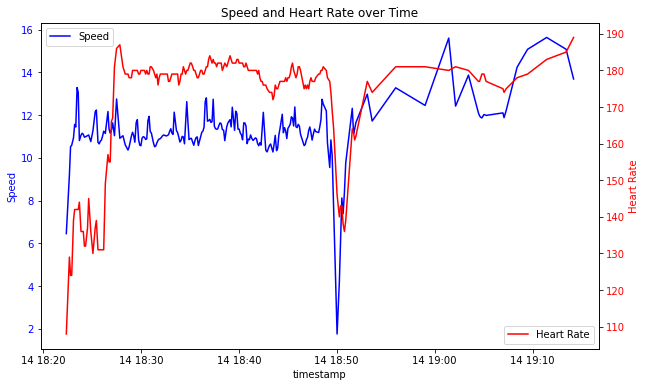

In [114]:

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=filtered_df, x='timestamp', y='speed', ax=ax1, label='Speed', color='blue')
ax1.set_ylabel('Speed', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(data=filtered_df, x='timestamp', y='heart_rate', ax=ax2, label='Heart Rate', color='red')
ax2.set_ylabel('Heart Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set title and show the plot
plt.title('Speed and Heart Rate over Time')
plt.show()

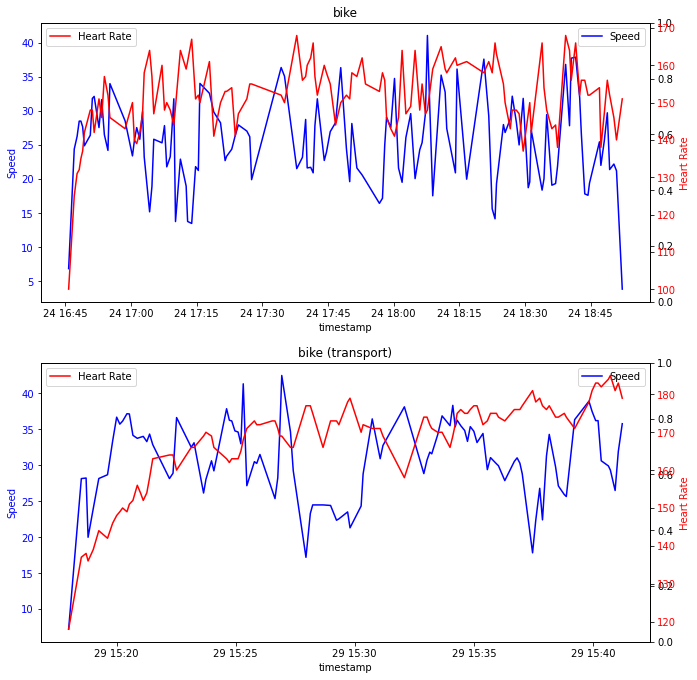

In [126]:

def plot_sport_data(sport, df, ax1, ax2):
    ax2 = plt.gca() 
    filtered_df = df[df['sport'] == sport]
    
    if filtered_df.empty:
        return
    
    first_row = filtered_df.iloc[0]
    
    # Create a new dataframe from the first row
    new_df = pd.DataFrame([first_row])
    new_df = new_df[['timestamp', 'heart_rate', 'speed']]
    
    # Explode the dataframe
    exploded_df = new_df.explode('timestamp').reset_index(drop=True)
    exploded_df['heart_rate'] = new_df['heart_rate'].explode().reset_index(drop=True)
    exploded_df['speed'] = new_df['speed'].explode().reset_index(drop=True)
    exploded_df['timestamp'] = pd.to_datetime(exploded_df['timestamp'], unit='s')
    exploded_df['time_diff'] = exploded_df['timestamp'].diff().dt.total_seconds()

    time_diff_threshold = 20
    # guarentee the resulted df has at least 100 rows
    while True:
        filtered_df = exploded_df[(exploded_df['time_diff'] >= time_diff_threshold) | (exploded_df['time_diff'].isna())]
        if len(filtered_df) >= 100 or time_diff_threshold <= 0:
            break
        time_diff_threshold -= 1

    filtered_df = filtered_df.drop(columns=['time_diff'])

    
    sns.lineplot(data=filtered_df, x='timestamp', y='speed', ax=ax1, label='Speed', color='blue')
    ax1.set_ylabel('Speed', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    sns.lineplot(data=filtered_df, x='timestamp', y='heart_rate', ax=ax2, label='Heart Rate', color='red')
    ax2.set_ylabel('Heart Rate', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax1.set_title(sport)

# List of sports
# sports = ['bike', 'bike (transport)', 'run', 'kayaking', 'indoor cycling', 'mountain bike', 'orienteering', 
#           'core stability training', 'walk', 'cross-country skiing', 'fitness walking', 'roller skiing', 
#           'skate', 'hiking', 'horseback riding']

sports = ['bike', 'bike (transport)']

# # Create subplots with 1 column and a number of rows equal to the number of sports
fig, axes = plt.subplots(nrows=len(sports), ncols=1, figsize=(10, 5 * len(sports)))  # Adjusted figsize for better layout
fig.tight_layout(pad=4.0)

for i, sport in enumerate(sports):
    plot_sport_data(sport, df, axes[i], axes[i].twinx())

plt.show()

